# Phase-amplitude coupling: processing and estimation

This notebook goes processes a signal in order to estimate the amount of phase-amplitude coupling within it. It begins with a raw signal with multiple types of noise and removes them. It then creates a comodulogram to visualize phase-amplitude coupling and the improvement in its estimation after artifact removal.

Required libraries:
* [tools](https://github.com/srcole/tools)
* [pacpy](https://github.com/voytekresearch/pacpy)

### Standard Imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

### Load data

In [2]:
x = np.load('./data.npy')
Fs = 512.

### Visualize data
Note the low-frequency trend and the high-frequency noise

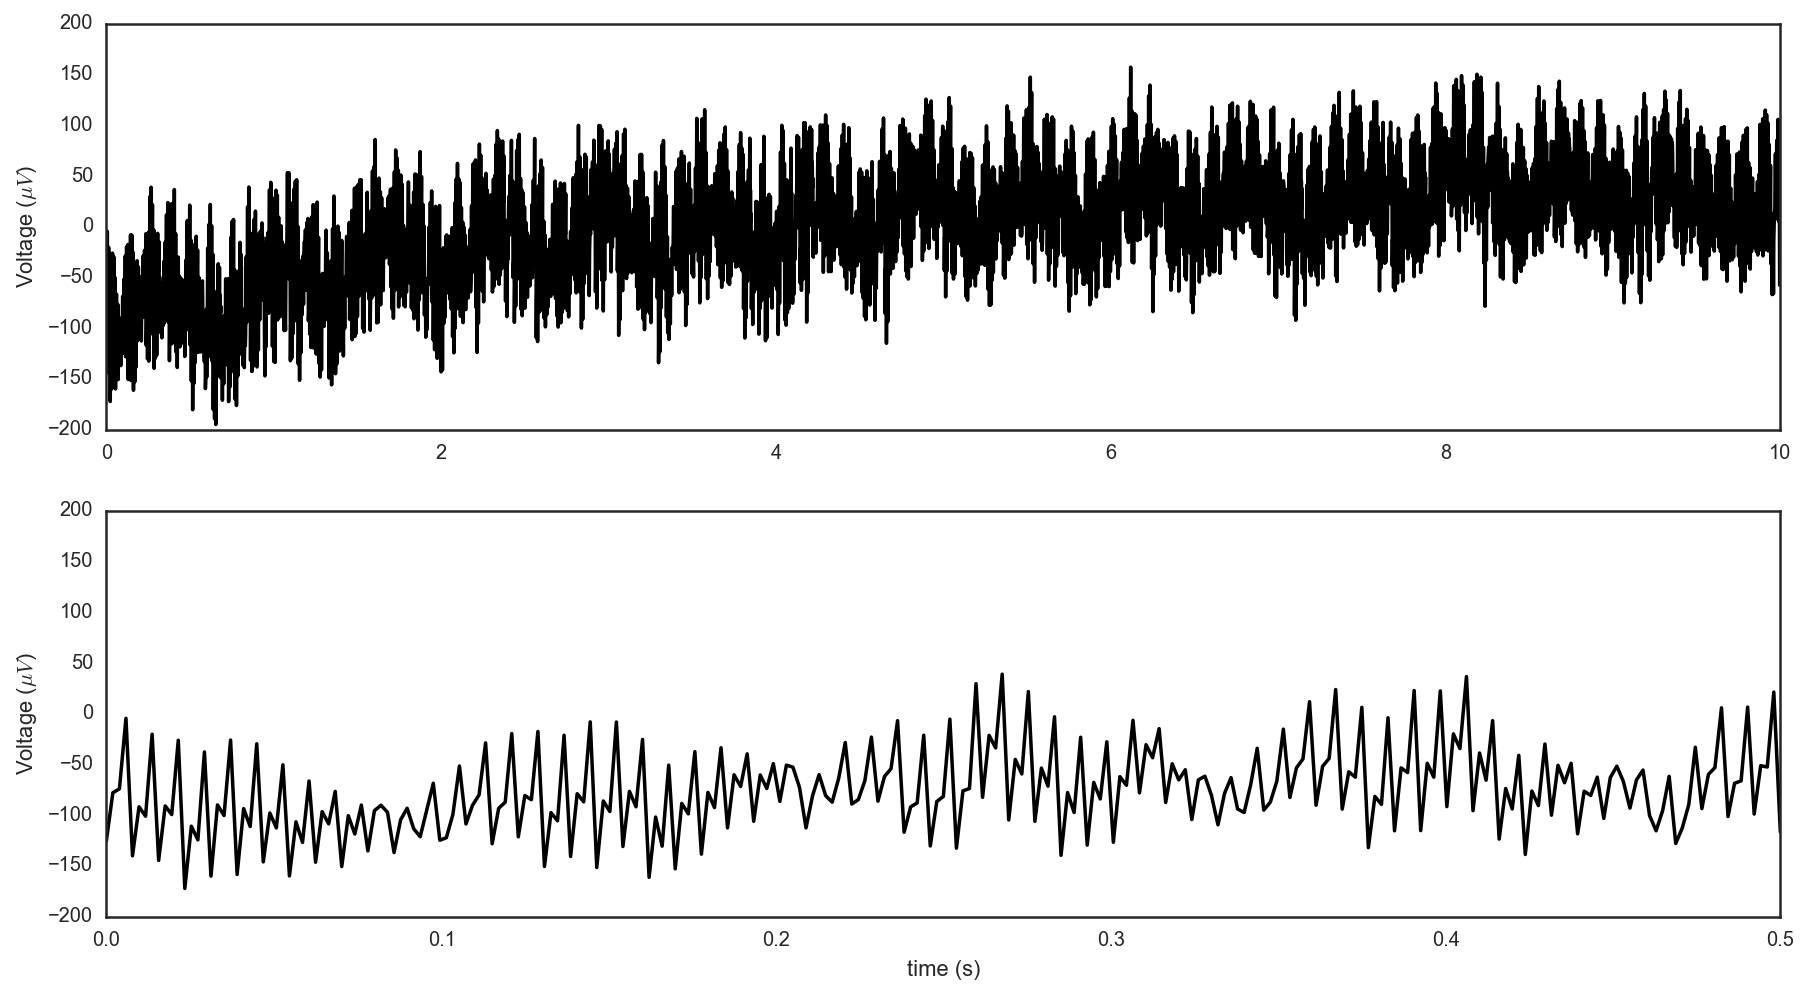

In [3]:
# Plot time series
tlim = (0,.5)
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(np.arange(0,10+1/Fs,1/Fs),x,'k')
plt.ylabel('Voltage ($\mu V$)')

plt.subplot(2,1,2)
plt.plot(np.arange(0,10+1/Fs,1/Fs),x,'k')
plt.xlim(tlim)
plt.xlabel('time (s)')
plt.ylabel('Voltage ($\mu V$)')

In [4]:
# Calculate power spectrum
from tools.spec import fftmed
Hzmed = 1
f, psd = fftmed(x, Fs=Fs, Hzmed = Hzmed)
psd = np.log10(psd)

(3, 9)

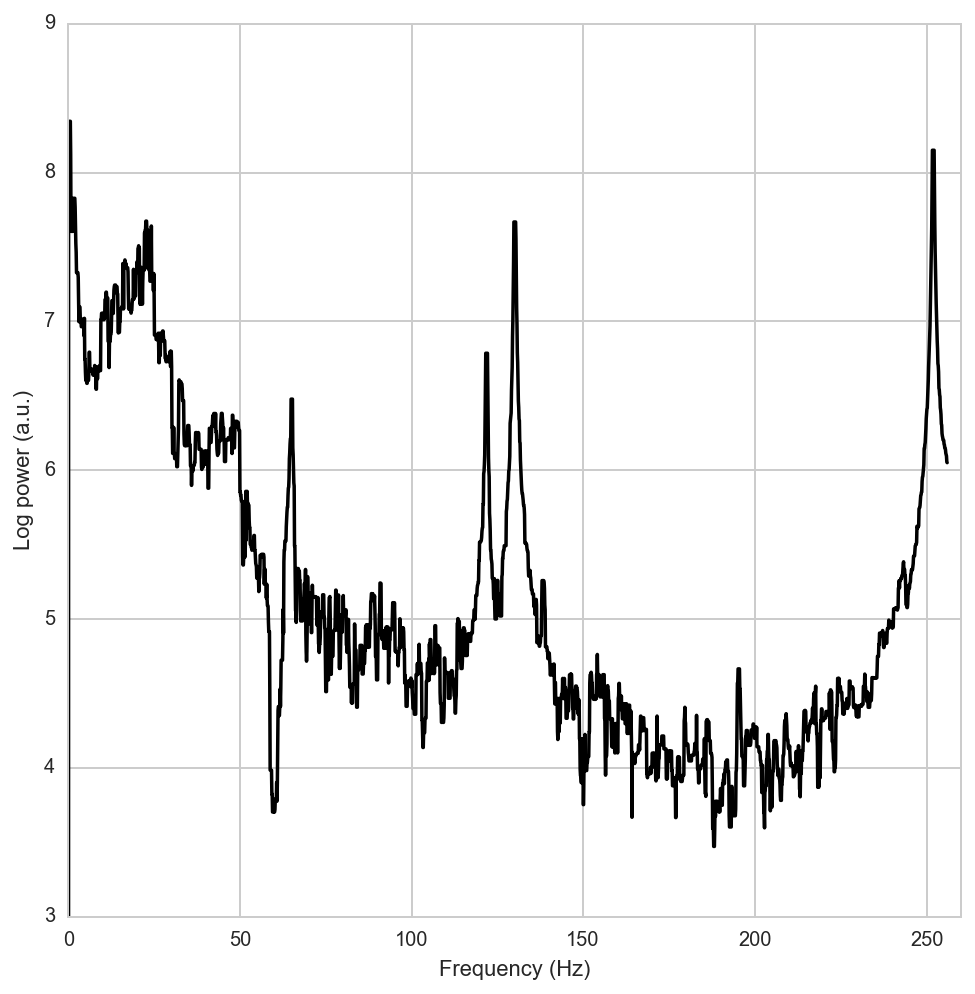

In [5]:
# Plot power spectrum
flim = (0,260)
plt.figure(figsize=(8,8))
plt.plot(f,psd,'k')
plt.ylabel('Log power (a.u.)')
plt.xlabel('Frequency (Hz)')
plt.xlim(flim)
plt.ylim((3,9))

# Artifact removal: Broad bandpass raw signal
Looking at the raw signal, it appears that the quite stationary low frequency oscillation and trend are non-physiological, or at least, are not the signal of interested for phase-amplitude coupling analysis. Therefore, they are removed here.

In [6]:
cf = (4,200)
from tools.spec import firfedge
xbb = firfedge(x,cf,Fs)

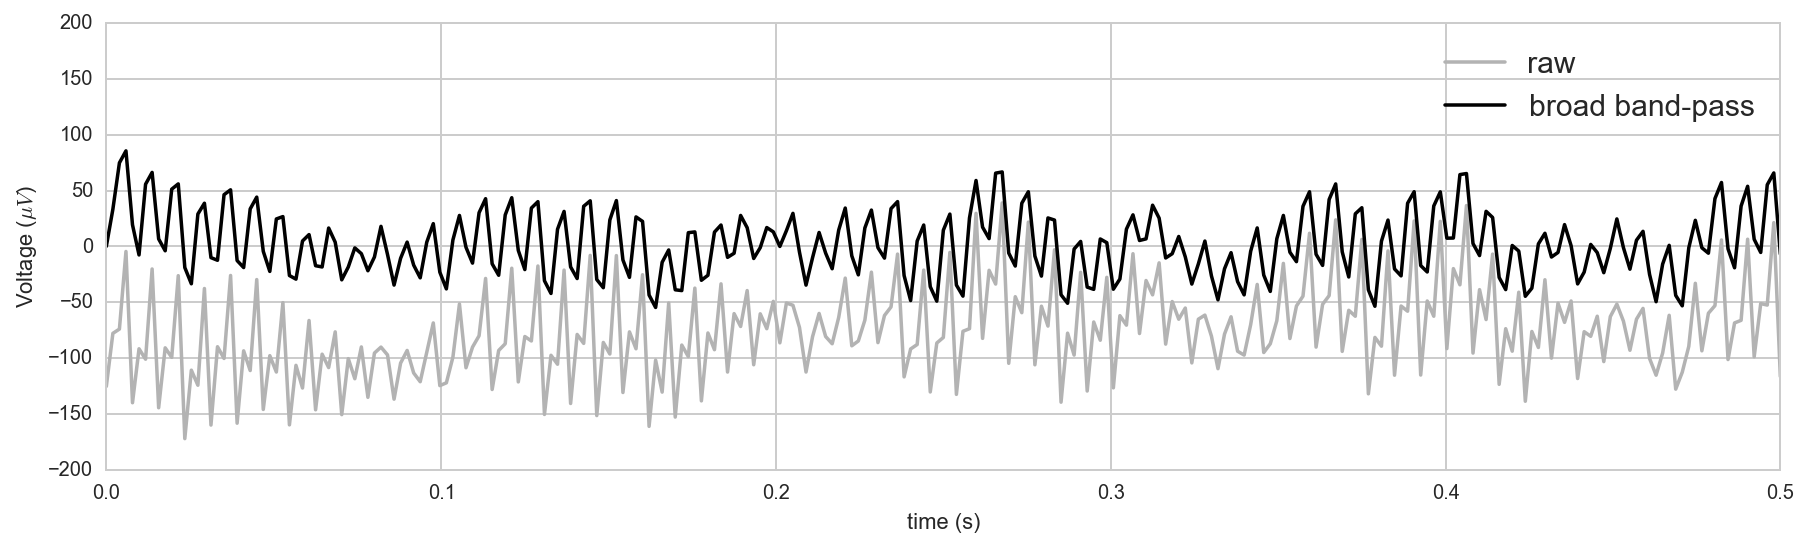

In [7]:
# Plot change in time series
tlim = (0,.5)
plt.figure(figsize=(15,4))
plt.plot(np.arange(0,10+1/Fs,1/Fs),x,color='0.7',label='raw')
plt.plot(np.arange(0,10+1/Fs,1/Fs),xbb,'k',label='broad band-pass')
plt.xlim(tlim)
plt.legend(loc='best',fontsize=15)
plt.xlabel('time (s)')
plt.ylabel('Voltage ($\mu V$)')

(3, 9)

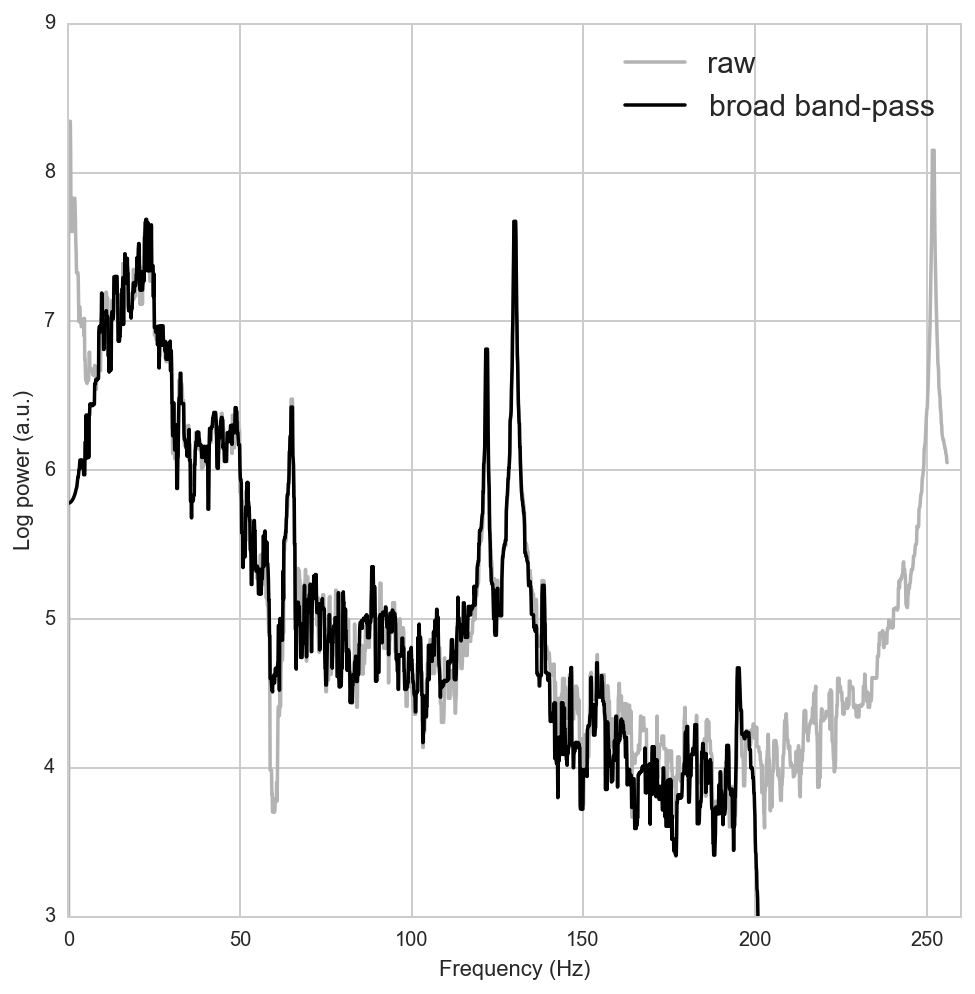

In [8]:
# Plot change in power spectrum
_, psdbb = fftmed(xbb, Fs=Fs, Hzmed = Hzmed)
psdbb = np.log10(psdbb)

flim = (0,260)
plt.figure(figsize=(8,8))
plt.plot(f,psd,color='0.7',label='raw')
plt.plot(f,psdbb,'k',label='broad band-pass')
plt.legend(loc='best',fontsize=15)
plt.ylabel('Log power (a.u.)')
plt.xlabel('Frequency (Hz)')
plt.xlim(flim)
plt.ylim((3,9))

# Remove high frequency artifacts
Sharp peaks in the power spectrum due to electrical noise during recording should be removed.

In [9]:
from tools.spec import notch

cfs = [65,128,195]
bws = [5,30,1]
Nfilters = len(cfs)
for f in range(Nfilters):
    if f == 0:
        xclean = notch(xbb,cfs[f],bws[f],Fs=Fs)
    else:
        xclean = notch(xclean,cfs[f],bws[f],Fs=Fs)

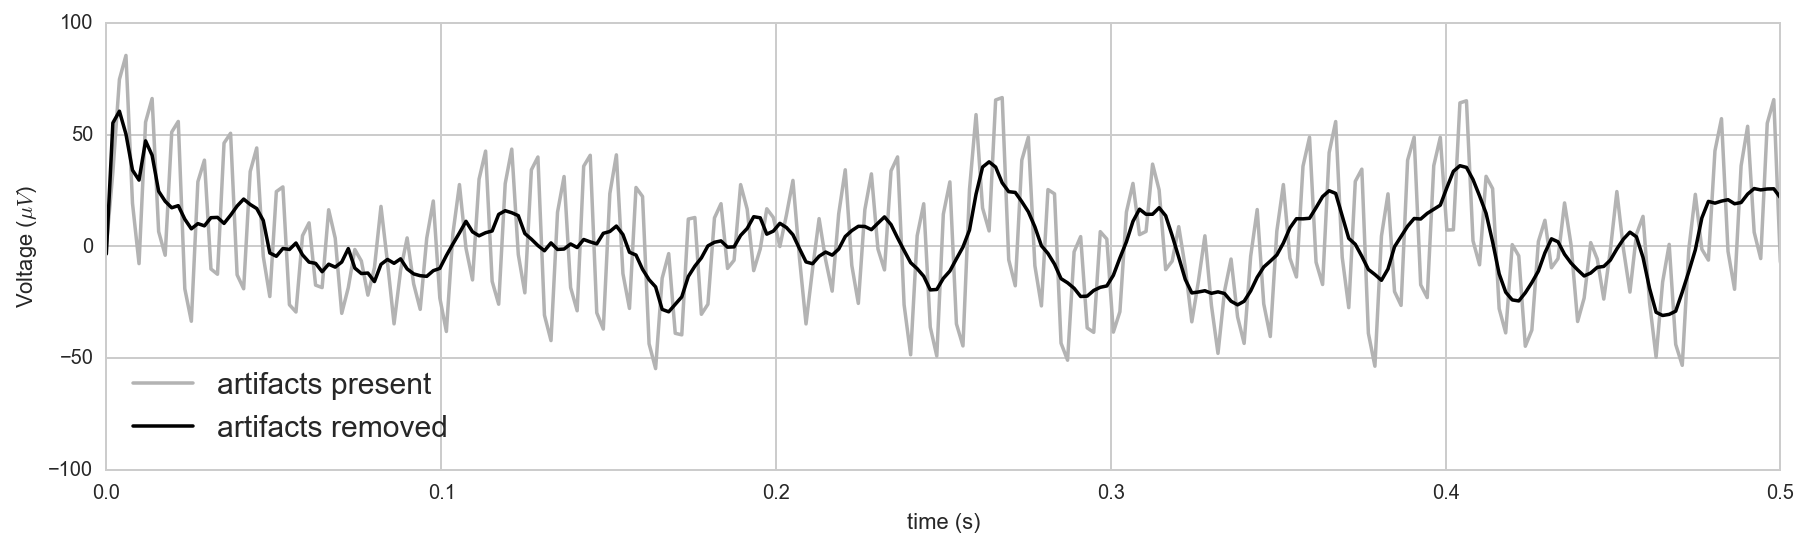

In [10]:
# Plot change in time series
tlim = (0,.5)
plt.figure(figsize=(15,4))
plt.plot(np.arange(0,10+1/Fs,1/Fs),xbb,color='0.7',label='artifacts present')
plt.plot(np.arange(0,10+1/Fs,1/Fs),xclean,'k',label='artifacts removed')
plt.xlim(tlim)
plt.legend(loc='best',fontsize=15)
plt.xlabel('time (s)')
plt.ylabel('Voltage ($\mu V$)')

(3, 9)

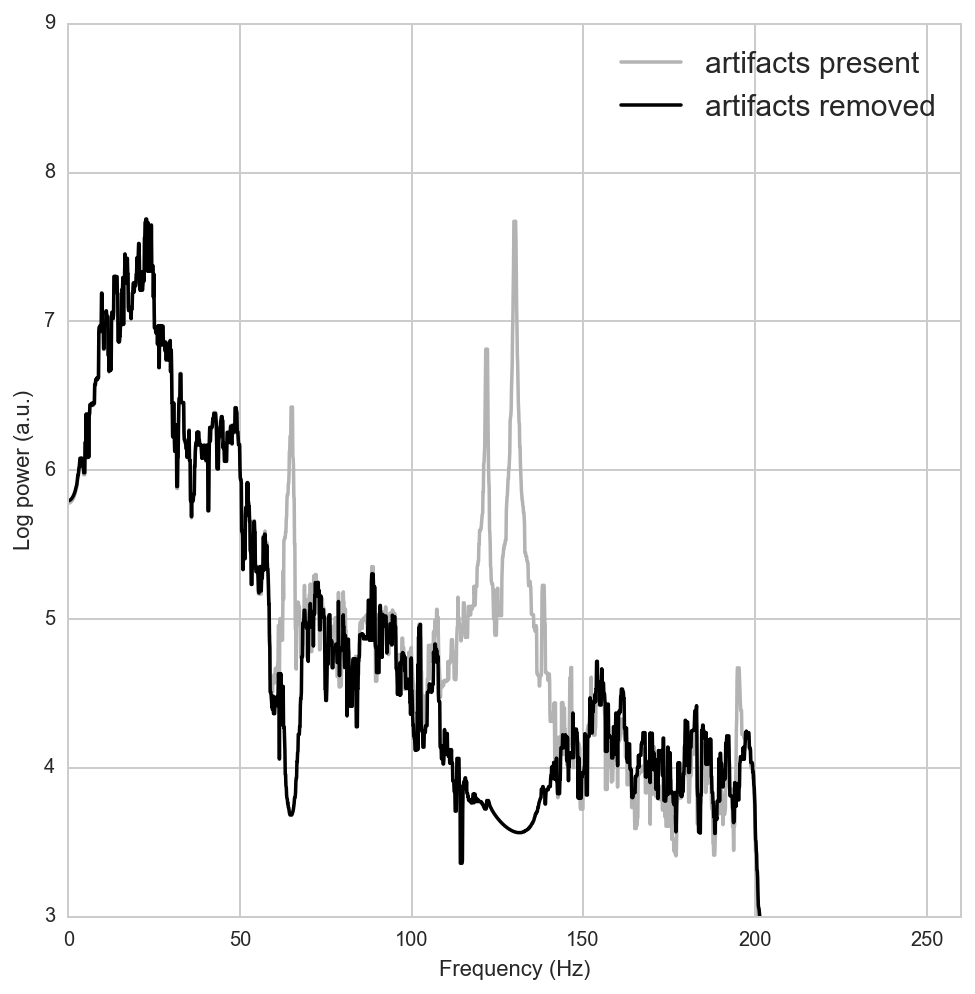

In [11]:
# Plot change in power spectrum
Hzmed = 1
f, psdclean = fftmed(xclean, Fs=Fs, Hzmed = Hzmed)
psdclean = np.log10(psdclean)

flim = (0,260)
plt.figure(figsize=(8,8))
plt.plot(f,psdbb,color='0.7',label='artifacts present')
plt.plot(f,psdclean,'k',label='artifacts removed')
plt.legend(loc='best',fontsize=15)
plt.ylabel('Log power (a.u.)')
plt.xlabel('Frequency (Hz)')
plt.xlim(flim)
plt.ylim((3,9))

# Remove edge artifacts
Because we have filtered the data, the edges of the resultant time series have artifacts due to the limitations of convolution on a finite-length time series. The lowest cutoff frequency used in the filter was 4Hz, therefore the number of samples removed from each edge are 3 cycles of this frequency.

In [12]:
lof = 4
from tools.spec import rmvedge
xcleantrim = rmvedge(xclean,lof,Fs)

# Comodulogram: PAC
Estimate phase-amplitude coupling between multiple narrow frequencyu bands in the processed and unprocessed signals.

In [13]:
# Parameters
fp = (6,40)
fa = (20,200)
dp = 4
da = 8
pac_method = 'mi_tort'

f_phases = np.arange(fp[0], fp[1], dp)
f_amps = np.arange(fa[0], fa[1], da)

In [14]:
# Calculate comods
from pacpy.pac import comodulogram
comodbad = comodulogram(x,x, fp, fa, dp, da,fs=Fs, pac_method=pac_method)
comodgood = comodulogram(xcleantrim,xcleantrim, fp, fa, dp, da,fs=Fs, pac_method=pac_method)

C:\Users\Scott\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


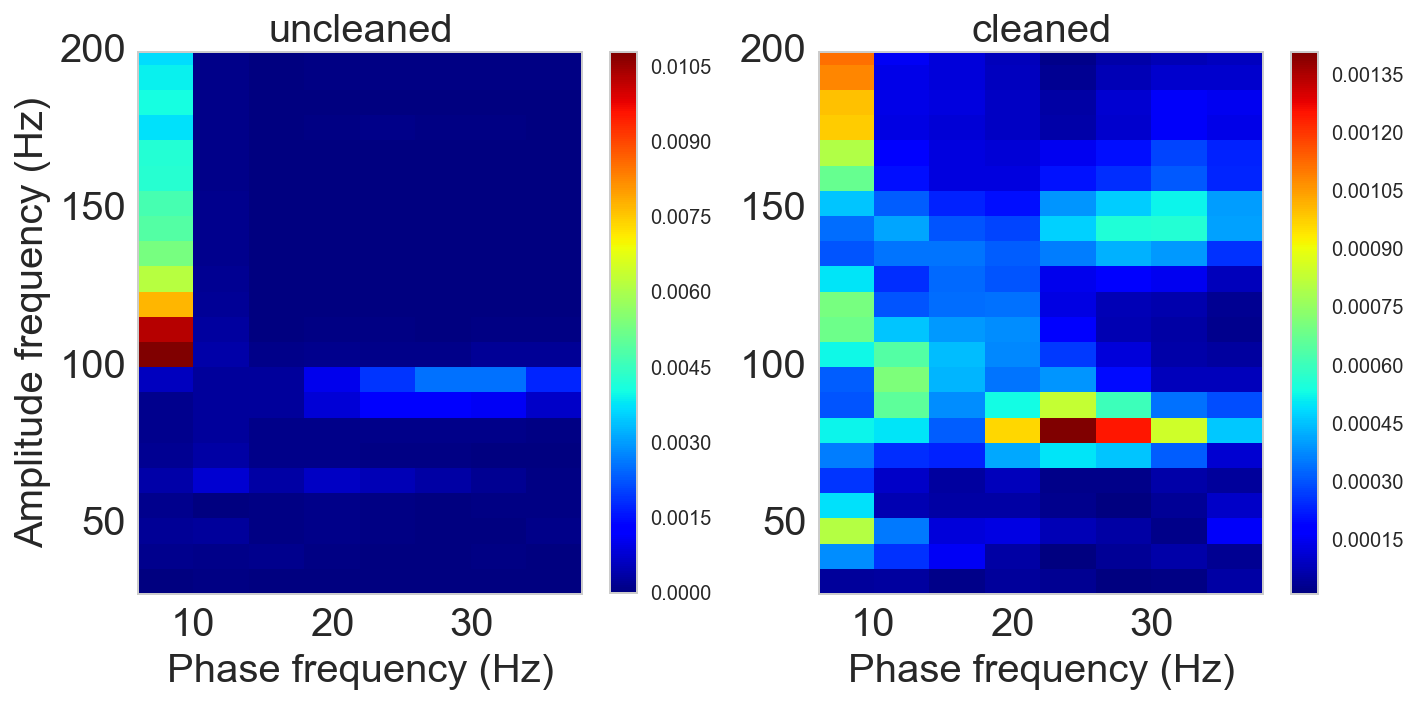

In [15]:
from matplotlib import cm
climraw = (0,.01)
climhi = (0,.01)
clim2 = (0,.01)

plt.figure(figsize=(10,5))
plt.subplot(1,2, 1)
plt.pcolor(f_phases, f_amps+da, comodbad.T, cmap=cm.jet)
plt.axis([f_phases[0], f_phases[-1], f_amps[0]+da, f_amps[-1]])
plt.colorbar()
#plt.clim(climraw)
plt.title('uncleaned', size=20)
plt.yticks(np.arange(50,250,50),size=20)
plt.xticks(np.arange(10,40,10),size=20)
plt.xlabel('Phase frequency (Hz)', size=20)
plt.ylabel('Amplitude frequency (Hz)', size=20)

plt.subplot(1,2, 2)
plt.pcolor(f_phases, f_amps+da, comodgood.T, cmap=cm.jet)
plt.axis([f_phases[0], f_phases[-1], f_amps[0]+da, f_amps[-1]])
plt.colorbar()
#plt.clim(climraw)
plt.title('cleaned', size=20)
plt.yticks(np.arange(50,250,50),size=20)
plt.xticks(np.arange(10,40,10),size=20)
plt.xlabel('Phase frequency (Hz)', size=20)

plt.tight_layout()

# Conclusions.
Notice that the raw voltage series contained artifacts that resulted in a comodulogram that did not have evident PAC. However, after removing these artifacts, the PAC between beta and gamma frequencies became clear in the comodulogram.